# Homework03:  Topic Modeling with Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

In [17]:
import numpy as np
import pandas as pd

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [18]:
#1. distance functions
def Euc(v1,v2, axis = None):
    return np.sqrt(np.sum((v1-v2)**2,axis = axis))
def sEuc(v1,v2, axis = None):
    return np.sum((v1-v2)**2, axis = axis)
def cosdis(v1,v2, axis = None):
    result = np.dot(v1.squeeze(),v2.T)/(np.linalg.norm(v1, axis = axis).T * np.linalg.norm(v2[:,np.newaxis],axis = axis)) 
    return  result

In [19]:
#2. row dist
def dist1(M, distance_func):
    result = np.zeros(shape = (M.shape[0],M.shape[0]))
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            result[i,j] = distance_func(M[i,:],M[j,:])
    return result

In [20]:
#3. col dist
def dist2(M, distance_func):
    result = np.zeros(shape = (M.shape[1],M.shape[1]))
    for i in range(M.shape[1]):
        for j in range(M.shape[1]):
            result[i,j] = distance_func(M[:,i],M[:,j])
    return result

In [21]:
#4. row dist2
def dist3(M, distance_func):
    result = distance_func(M[:,np.newaxis], M, axis = 2)
    return result

In [22]:
#5. col dist2
def dist4(M, distance_func):
    M = M.T
    result = distance_func(M[:,np.newaxis], M, axis = 2)
    return result

In [23]:
M = np.arange(20).reshape(4,5)

In [24]:
rowEuc = np.allclose(dist1(M,Euc),dist3(M,Euc)) 
rowsEuc = np.allclose(dist1(M,sEuc),dist3(M,sEuc))
rowcos = np.allclose(dist1(M,cosdis),dist3(M,cosdis))
colEuc = np.allclose(dist2(M,Euc),dist4(M,Euc))
colsEuc = np.allclose(dist2(M,sEuc),dist4(M,sEuc))
colcos = np.allclose(dist2(M,cosdis),dist4(M,cosdis))

In [25]:
rowEuc, rowsEuc, rowcos, colEuc, colsEuc, colcos

(True, True, True, True, True, True)

**Exercise 2 (20 points)**. 

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [26]:
import string

In [27]:
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

In [28]:
def tf(docs):
    words = [doc.lower().translate(str.maketrans("","",string.punctuation)).split() for i,doc in docs.items()]
    dic = {i for word in words for i in word}
    table = np.zeros(shape = (len(dic),len(words)),dtype = int)
    for i, word in enumerate(dic):
        for j, doc in enumerate(words):
            table[i,j] = doc.count(word)
    result = pd.DataFrame(table, columns = docs, index = dic)
    return(result)

In [29]:
def idf(docs):
    words = [doc.lower().translate(str.maketrans("","",string.punctuation)).split() for i,doc in docs.items()]
    dic = {i for word in words for i in word}
    table = np.zeros(shape = (len(dic),len(words)),dtype = int)
    for i, word in enumerate(dic):
        for j, doc in enumerate(words):
            table[i,j] = doc.count(word)
    n = len(docs)
    df = np.where(table ==0,0,1).sum(axis=1)
    result = pd.DataFrame(np.log(n/(1+df)), index = dic)
    return(result)

In [30]:
def tf_idf(docs):
    words = [doc.lower().translate(str.maketrans("","",string.punctuation)).split() for i,doc in docs.items()]
    dic = {i for word in words for i in word}
    table1 = np.zeros(shape = (len(dic),len(words)),dtype = int)
    for i, word in enumerate(dic):
        for j, doc in enumerate(words):
            table1[i,j] = doc.count(word)
    n = len(docs)
    df = np.where(table1 == 0 ,0, 1).sum(axis = 1)
    table2 = np.log(n/(df+1))
    result = pd.DataFrame(table1*table2[:,np.newaxis], columns = docs, index = dic)
    return result

In [31]:
tf(docs)

,s1,s2,s3,s4
peacock,0,0,0,1
brown,1,1,0,0
dog,0,0,1,1
tiger,0,0,0,1
jumps,0,4,0,0
over,0,1,0,0
elephant,0,0,1,1
lion,0,0,0,1
quick,1,0,0,0
fox,1,1,0,0


In [32]:
idf(docs)

,0
peacock,0.693147
brown,0.287682
dog,0.287682
tiger,0.693147
jumps,0.693147
over,0.693147
elephant,0.287682
lion,0.693147
quick,0.693147
fox,0.287682


In [33]:
tf_idf(docs)

,s1,s2,s3,s4
peacock,0.000000,0.000000,0.000000,0.693147
brown,0.287682,0.287682,0.000000,0.000000
dog,0.000000,0.000000,0.287682,0.287682
tiger,0.000000,0.000000,0.000000,0.693147
jumps,0.000000,2.772589,0.000000,0.000000
over,0.000000,0.693147,0.000000,0.000000
elephant,0.000000,0.000000,0.287682,0.287682
lion,0.000000,0.000000,0.000000,0.693147
quick,0.693147,0.000000,0.000000,0.000000
fox,0.287682,0.287682,0.000000,0.000000


**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [34]:
import scipy.linalg as la
import scipy.stats as st

In [35]:
# 1.
def approx_svd(M,k):
    U,s,V = la.svd(M)
    Uk = U[:,:k]; sk = s[:k]; Vk = V[:k,:]
    approx = Uk @ np.diag(sk) @ Vk
    return approx

In [36]:
# 2.
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
M_2 = approx_svd(M,2)
M_2

array([[ 0.16205797,  0.40049828,  0.37895454,  0.46756626,  0.17595367,
        -0.05265495, -0.11514284, -0.15910198, -0.09183827],
       [ 0.14058529,  0.36980077,  0.32899603,  0.40042722,  0.16497247,
        -0.03281545, -0.07056857, -0.09676827, -0.04298073],
       [ 0.15244948,  0.50500444,  0.35793658,  0.41010678,  0.23623173,
         0.02421652,  0.05978051,  0.0868573 ,  0.12396632],
       [ 0.25804933,  0.84112343,  0.60571995,  0.69735717,  0.39231795,
         0.03311801,  0.08324491,  0.12177239,  0.18737973],
       [ 0.44878975,  1.23436483,  1.0508615 ,  1.26579559,  0.55633139,
        -0.07378998, -0.15469383, -0.20959816, -0.04887954],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.21846278,  0.54958058,  0.51096047,  0.62805802,  0

In [21]:
# 3.1
st.spearmanr(M,M_2)[0]

array([[ 1.        , -0.19245009,  0.        ,  0.07339758, -0.33333333,
        -0.17407766, -0.25819889, -0.33333333, -0.33333333,  0.02792359,
        -0.2508726 ,  0.02792359,  0.02787473, -0.36300672, -0.41812101,
        -0.41812101, -0.41812101, -0.47387047],
       [-0.19245009,  1.        ,  0.        , -0.12712835,  0.57735027,
        -0.30151134, -0.4472136 , -0.57735027, -0.19245009,  0.43528575,
         0.77248728,  0.43528575,  0.43452409,  0.82220642, -0.14484136,
        -0.14484136, -0.14484136, -0.04828045],
       [ 0.        ,  0.        ,  1.        ,  0.43822991,  0.        ,
        -0.21320072, -0.31622777, -0.40824829, -0.40824829,  0.61558701,
         0.4608824 ,  0.61558701,  0.61450987,  0.35909242, -0.66571902,
        -0.66571902, -0.66571902, -0.61450987],
       [ 0.07339758, -0.12712835,  0.43822991,  1.        , -0.33028913,
        -0.17248787, -0.25584086, -0.33028913, -0.33028913,  0.65943446,
         0.35445878,  0.65943446,  0.65828059,  0.253

In [43]:
np.triu(G1_cor, k=1)

array([[ 0.        , -0.19245009,  0.        ,  0.07339758, -0.33333333],
       [ 0.        ,  0.        ,  0.        , -0.12712835,  0.57735027],
       [ 0.        ,  0.        ,  0.        ,  0.43822991,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.33028913],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [48]:
G1_cor

array([[ 1.        , -0.19245009,  0.        ,  0.07339758, -0.33333333],
       [-0.19245009,  1.        ,  0.        , -0.12712835,  0.57735027],
       [ 0.        ,  0.        ,  1.        ,  0.43822991,  0.        ],
       [ 0.07339758, -0.12712835,  0.43822991,  1.        , -0.33028913],
       [-0.33333333,  0.57735027,  0.        , -0.33028913,  1.        ]])

In [47]:
G1_cor.mean()

0.20846214930389023

In [51]:
G1_cor.sum()/np.prod(G1_cor.shape)

0.20846214930389023

In [53]:
# 3.2
G1 = M[:,:5]; G2 = M[:,-4:]
cor = st.spearmanr(G1,G2)[0]
G1_cor = cor[:5,:5]
G2_cor = cor[-4:,-4:]
cross_cor = cor[:5,-4:]
G1_group_cor = (G1_cor.sum() - 5)/(np.prod(G1_cor.shape) - 5)
G2_group_cor = (G2_cor.sum() - 5)/(np.prod(G2_cor.shape) - 5)
{'G1': G1_group_cor, 'G2': G2_group_cor, "cross": cross_cor.mean()}

{'G1': 0.010577686629862804,
 'G2': 0.38376477980342505,
 'cross': -0.3075621889055909}

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

In [60]:
import os
if os.getcwd() == "/home/jovyan/work/sta-663-2020/homework" : os.chdir('../')
os.getcwd()

'/home/jovyan/work/sta-663-2020'

In [61]:
import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))

In [62]:
result = tf_idf(docs)

In [63]:
# 1.
result.shape

(6906, 178)

In [64]:
# 2
tfidf_approx = approx_svd(result,10)
tfidf_approx

array([[-0.02471324,  0.04605859,  0.03102535, ...,  0.04642433,
         0.02107521,  0.01671913],
       [-0.00458   ,  0.01724327,  0.01815948, ...,  0.00433203,
         0.00486686,  0.00846292],
       [-0.01242284,  0.02359785,  0.014125  , ...,  0.0333916 ,
         0.0114609 ,  0.0064425 ],
       ...,
       [ 0.03528954,  0.0210099 ,  0.04165214, ...,  0.05646047,
         0.02319226,  0.01187062],
       [-0.06399633,  0.1140044 ,  0.1300546 , ..., -0.00981625,
         0.02653949,  0.06848838],
       [ 0.00685851,  0.0722536 ,  0.03991828, ...,  0.10738222,
         0.03823803,  0.01339978]])

In [65]:
import scipy.cluster as ct

In [66]:
#3.
tfidf_approx = approx_svd(result,k = 100)
Z = ct.hierarchy.complete(tfidf_approx)

{'color_list': ['g', 'g', 'r', 'c', 'c', 'c', 'c', 'c', 'b', 'b'],
 'dcoord': [[0.0, 0.0, 0.0, 0.0],
  [0.0, 27.54442868312889, 27.54442868312889, 0.0],
  [0.0, 35.66351898329464, 35.66351898329464, 0.0],
  [0.0, 8.973752510649224, 8.973752510649224, 0.0],
  [0.0, 81.3457645662384, 81.3457645662384, 0.0],
  [0.0, 85.4721634507212, 85.4721634507212, 81.3457645662384],
  [0.0, 88.57237263892421, 88.57237263892421, 85.4721634507212],
  [8.973752510649224, 98.77127010489771, 98.77127010489771, 88.57237263892421],
  [35.66351898329464,
   116.12575739206329,
   116.12575739206329,
   98.77127010489771],
  [27.54442868312889,
   143.96340420103186,
   143.96340420103186,
   116.12575739206329]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [60.0, 60.0, 83.75, 83.75],
  [40.0, 40.0, 71.875, 71.875],
  [12.5, 12.5, 55.9375, 55.9375

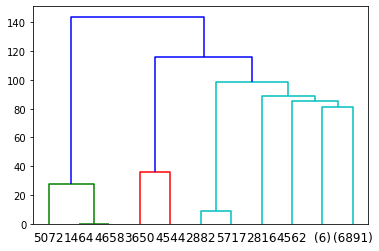

In [76]:
ct.hierarchy.dendrogram(Z, p = 5, truncate_mode= "level")

According to the number of colors in dendrogram, 3 clusters are likely to exist in these documents, because there are different main 3 components with colors. 

In [68]:
#4. 
with open("data/mystery.txt") as f:
    new = f.read()

In [69]:
words = new.lower().translate(str.maketrans("","",string.punctuation)).split()
tf_new = np.array([words.count(word) for word in result.index])
idf_docs = idf(docs)
tfidf_new = tf_new[:,np.newaxis] * idf_docs

In [70]:
U,s,V = la.svd(result)
q = tfidf_new.T @ U[:,:100] @ np.diag(1/s[:100])
docs_V = approx_svd(result,100).T @ U[:,:100] @ np.diag(1/s[:100])

In [71]:
similar = np.zeros(docs_V.shape[0])
for i in range(docs_V.shape[0]):
    similar[i] = cosdis(q,docs_V[i,:])

In [72]:
similar = pd.DataFrame(similar, index=result.columns, columns= ["similarity"])

In [73]:
top10 = similar.sort_values(by = "similarity",ascending=False).head(10)
bottom10 = similar.sort_values(by = "similarity",ascending=False).tail(10)

In [74]:
top10

,similarity
Diabetes Numeracy and Blood Glucose Control: Association With Type of Diabetes and Source of Care.,0.639125
Disparities in Postpartum Follow-Up in Women With Gestational Diabetes Mellitus.,0.499503
Feasibility of the SMART Project: A Text Message Program for Adolescents With Type 1 Diabetes.,0.498692
"Health Care Utilization Among U.S. Adults With Diagnosed Diabetes, 2013.",0.489068
Efficacy of a Transition Theory-Based Discharge Planning Program for Childhood Asthma Management.,0.458502
Outcomes of a Diabetes Education Program for Registered Nurses Caring for Individuals With Diabetes.,0.430134
Inducible laryngeal obstruction during exercise: moving beyond vocal cords with new insights.,0.417749
"""Living Well with Diabetes"": Evaluation of a Pilot Program to Promote Diabetes Prevention and Self-Management in a Medically Underserved Community.",0.397457
"Demographic Disparities Among Medicare Beneficiaries with Type 2 Diabetes Mellitus in 2011: Diabetes Prevalence, Comorbidities, and Hypoglycemia Events.",0.384353
A Multicenter Outcomes Analysis of Children With Severe Rhino/Enteroviral Respiratory Infection*,0.383269


In [75]:
bottom10

,similarity
Boronate Probes for the Detection of Hydrogen Peroxide Release from Human Spermatozoa.,-0.041966
"Antibodies to the Plasmodium falciparum proteins MSPDBL1 and MSPDBL2 opsonise merozoites, inhibit parasite growth and predict protection from clinical malaria.",-0.046423
CD4 T-cell subsets in malaria: TH1/TH2 revisited.,-0.056098
Adjuvant poly(N-isopropylacrylamide) generates more efficient monoclonal antibodies against truncated recombinant histidine-rich protein 2 of Plasmodium falciparum for malaria diagnosis.,-0.056822
Nerve Growth Factor Potentiates Nicotinic Synaptic Transmission in Mouse Airway Parasympathetic Neurons.,-0.086970
Time-to-infection by Plasmodium falciparum is largely determined by random factors.,-0.087473
IRGM3 contributes to immunopathology and is required for differentiation of antigen-specific effector CD8+ T cells in experimental cerebral malaria.,-0.100283
CD40 Is Required for Protective Immunity against Liver Stage Plasmodium Infection.,-0.103561
Pre- and Postnatal Risk Factors in Relation to Allergic Rhinitis in School-Aged Children in China.,-0.111873
NFATc1 deletion in T lymphocytes inhibits the allergic trait in a murine model of asthma.,-0.120838


**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```